# Optical Wave Gauging for Google Colab

by Daniel Buscombe, daniel.buscombe@nau.edu

This notebook is part of https://github.com/dbuscombe-usgs/OpticalWaveGauging_DNN

### Train an optical wave gage (OWG) to estimate wave height from an image


First, enable a GPU runtime: 

In Colab, go to runtime > change runtime type > hardware accelerator: GPU


Workflow:

1. Write a configuration file - this is how you interact with OWG functions
2. Download the data and model weights
3. Define the model
4. Generate test images and associated wave heights from the downloaded imagery
5. Use the model to estimate wave height for each image
6. Make plots

Import libraries

In [0]:
import numpy as np 
import pandas as pd 
import os, gc, requests, zipfile
import time, datetime, json
from glob import glob
from sklearn.model_selection import train_test_split

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

This notebook assumes you are in Google Colab. Therefore, switch to Tensorflow 2 and verify by printing the version, which should say '2.X.X' where X can be any number

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import mean_absolute_error

TensorFlow 2.x selected.
2.0.0


Write the configuration file using the magic command 'writefile'

In [4]:
%%writefile config_train.json
{
  "samplewise_std_normalization" : true,
  "samplewise_center"  : true,
  "input_image_format" : "jpg",
  "input_csv_file"     : "snap-training-dataset.csv", 
  "category"           : "H",
  "prc_lower_withheld": 0,
  "prc_upper_withheld": 0,
  
  "horizontal_flip"    : false,
  "vertical_flip"      : false,
  "rotation_range"     : 10,
  "width_shift_range"  : 0.1,
  "height_shift_range" : 0.1,
  "shear_range"        : 0.05,
  "zoom_range"         : 0.2,
  "fill_mode"          : "reflect",
  
  "img_size"           : 128,
  "num_epochs"         : 200,
  "test_size"          : 0.4,
  "dropout_rate"       : 0.5,
  "epsilon"            : 0.0001,
  "min_lr"             : 0.0001,
  "factor"             : 0.8
}

Writing config_train.json


Open the config file and read values into workspace. This might seem like a long-winded way of doing things -- and it is --- but this is how things are set up in the command line python scripts version of this workflow in `https://github.com/dbuscombe-usgs/OpticalWaveGauging_DNN/train_OWG.py` so it is maintained here for consistency

In [0]:
with open('config_train.json') as f:    
    config = json.load(f)

# config variables
imsize    = int(config["img_size"])
num_epochs = int(config["num_epochs"]) 
test_size = float(config["test_size"])
height_shift_range = float(config["height_shift_range"])
width_shift_range = float(config["width_shift_range"])
rotation_range = float(config["rotation_range"])
samplewise_std_normalization = config["samplewise_std_normalization"]
horizontal_flip = config["horizontal_flip"]
vertical_flip = config["vertical_flip"]
samplewise_center = config["samplewise_center"]
shear_range = float(config["shear_range"])
zoom_range = float(config["zoom_range"])
dropout_rate = float(config["dropout_rate"])
epsilon = float(config["epsilon"])
min_lr = float(config["min_lr"])
factor = float(config["factor"])
input_image_format = config["input_image_format"]
input_csv_file = config["input_csv_file"]
category = config["category"] 
fill_mode = config["fill_mode"]
prc_lower_withheld = config['prc_lower_withheld'] 
prc_upper_withheld = config['prc_upper_withheld']
IMG_SIZE = (imsize, imsize) 

Download a csv file from the github repository that contains the info we need to test the trained OWG model


In [6]:
!wget https://github.com/dbuscombe-usgs/OpticalWaveGauging_DNN/raw/master/snap-training-dataset.csv

--2019-11-12 01:17:24--  https://github.com/dbuscombe-usgs/OpticalWaveGauging_DNN/raw/master/snap-training-dataset.csv
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dbuscombe-usgs/OpticalWaveGauging_DNN/master/snap-training-dataset.csv [following]
--2019-11-12 01:17:24--  https://raw.githubusercontent.com/dbuscombe-usgs/OpticalWaveGauging_DNN/master/snap-training-dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43795 (43K) [text/plain]
Saving to: ‘snap-training-dataset.csv’

snap-training-datas 100%[===================>]  42.77K  --.-KB/s    in 0.01s   

2019-11-12 01:17:25 (4.09 MB/s) -

define a function to download files from google drive

In [0]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)	

Download the zipped file, unzip it, and delete the zipped file

In [8]:
image_dir = 'snap_images'+os.sep+'data'

url = 'https://drive.google.com/file/d/11xd3HWcfEE_yMYcSsr1StFFPSdXNAjKH/view?usp=sharing'		
if not os.path.isdir(os.path.join(os.getcwd(),image_dir)):
  file_id = '11xd3HWcfEE_yMYcSsr1StFFPSdXNAjKH' 
  destination = 'snap_images.zip'
  download_file_from_google_drive(file_id, destination)	
  print('download complete ... unzipping')	
  zip_ref = zipfile.ZipFile(destination, 'r')
  zip_ref.extractall(os.getcwd())
  zip_ref.close()
  os.remove(destination)

download complete ... unzipping


In [0]:
def get_and_tidy_df(base_dir, input_csv_file, image_dir, category):
	df = pd.read_csv(os.path.join(base_dir, input_csv_file))
	df['path'] = df['id'].map(lambda x: os.path.join(base_dir,
		                                                image_dir,'{}'.format(x)))
		
	df = df.rename(index=str, columns={" H": "H", " T": "T"})   
	
	if category == 'H':
		mean = df['H'].mean() 
		div = df['H'].std() 
		df['zscore'] = df['H'].map(lambda x: (x-mean)/div)
	elif category == 'T':
		mean = df['T'].mean() 
		div = df['T'].std() 
		df['zscore'] = df['T'].map(lambda x: (x-mean)/div)			
	else:
		print("Unknown category: "+str(category))
		print("Fix config file, exiting now ...")
		sys.exit()
	
	df.dropna(inplace = True)
	try:
		df = df.sort_values(by='time', axis=0)
	except:
		df = df.sort_values(by='id', axis=0)

	if category == 'H':
		df['category'] = pd.cut(df['H'], 10)
	else:
		df['category'] = pd.cut(df['T'], 8)
		
	df['index1'] = df.index; new_df = df.groupby(['category']).apply(lambda x: x.sample(int(len(df)/2), replace = True)).reset_index(drop = True)

	return new_df, df  

Get a dataframe to generate test and train data from

In [0]:
# call the utils.py function get_and_tidy_df            	
new_df, df = get_and_tidy_df(os.getcwd(), input_csv_file, image_dir, category)

Get train and test splits and define the generator function that will do the image augmentation

In [11]:
print('New Data Size:', new_df.shape[0], 'Old Size:', df.shape[0])
      
train_df, valid_df = train_test_split(new_df, 
                    test_size = test_size, 
                    random_state = 2018,
                    stratify = new_df['category'])
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

im_gen = ImageDataGenerator(samplewise_center=samplewise_center,
                samplewise_std_normalization=samplewise_std_normalization,
                horizontal_flip = horizontal_flip,  
                vertical_flip = vertical_flip, 
                height_shift_range = height_shift_range, 
                width_shift_range = width_shift_range, 
                rotation_range = rotation_range,
                shear_range = shear_range, 
                fill_mode = fill_mode,
                zoom_range= zoom_range) 

New Data Size: 4900 Old Size: 980
train 2940 validation 1960


Make a generator from a dataframe	

In [0]:
def gen_from_def(IMG_SIZE, df, image_dir, category, im_gen):

	gen = im_gen.flow_from_dataframe(dataframe=df,
								  directory=image_dir,
								  x_col="path",
								  y_col=category,
								  target_size=IMG_SIZE,
								  batch_size=len(df),
								  color_mode = 'grayscale',
								  shuffle=False,
								  class_mode='raw')
								  	
	ex_X, ex_Y = next(gen)
	return ex_X, ex_Y

Get the train and test images and associated wave heights. This takes a while 

In [13]:
train_X, train_Y = gen_from_def(IMG_SIZE, train_df, image_dir, category, im_gen)
test_X, test_Y = gen_from_def(IMG_SIZE, valid_df, image_dir, category, im_gen)

Found 2940 validated image filenames.
Found 1960 validated image filenames.


In [19]:
batch_size = 16

weights_path='waveheight_weights_model1_'+str(batch_size)+'batch.best.nearshore.hdf5'	
      
print(weights_path)

waveheight_weights_model1_16batch.best.nearshore.hdf5


Create a model checkpoint, and training utilities such as early stopping, and reduce learning rate on a plateau in validaion loss

In [21]:
model_checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = True)

reduceloss_plat = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=5, verbose=1, mode='auto', epsilon=epsilon, cooldown=5, min_lr=min_lr)
earlystop = EarlyStopping(monitor="val_loss", mode="min", patience=25) 
callbacks_list = [model_checkpoint, earlystop, reduceloss_plat]	

In [0]:
# mean absolute error
def mae_metric(in_gt, in_pred):
    return mean_absolute_error(in_gt, in_pred)

Set model and print a summary

In [23]:
base_model = MobileNet(input_shape =  (IMG_SIZE[0], IMG_SIZE[1],1), include_top = False, weights = None)			
OWG = Sequential()
OWG.add(BatchNormalization(input_shape = (IMG_SIZE[0], IMG_SIZE[1],1)))
OWG.add(base_model)
OWG.add(BatchNormalization())
OWG.add(GlobalAveragePooling2D())
OWG.add(Dropout(0.5)) 
OWG.add(Dense(1, activation = 'linear' )) 

OWG.compile(optimizer = 'rmsprop', loss = 'mse', metrics = [mae_metric])
OWG.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 128, 128, 1)       4         
_________________________________________________________________
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 4, 1024)        4096      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,233,413
Trainable params: 3,209,475
Non-trainable params: 23,938
_______________________________________

In [24]:
history = OWG.fit(train_X, train_Y, batch_size=batch_size, 
                  validation_data = (test_X, test_Y),
                  epochs=num_epochs, callbacks = callbacks_list)

OWG.load_weights(weights_path)

Train on 2940 samples, validate on 1960 samples
Epoch 1/200
2928/2940 [============================>.] - ETA: 0s - loss: 0.9997 - mae_metric: 0.7068
Epoch 00001: val_loss improved from inf to 0.43744, saving model to waveheight_weights_model1_16batch.best.nearshore.hdf5
2940/2940 [==============================] - 21s 7ms/sample - loss: 0.9969 - mae_metric: 0.7058 - val_loss: 0.4374 - val_mae_metric: 0.5605
Epoch 2/200
2928/2940 [============================>.] - ETA: 0s - loss: 0.2613 - mae_metric: 0.4113
Epoch 00002: val_loss did not improve from 0.43744
2940/2940 [==============================] - 14s 5ms/sample - loss: 0.2611 - mae_metric: 0.4112 - val_loss: 0.4553 - val_mae_metric: 0.5727
Epoch 3/200
2928/2940 [============================>.] - ETA: 0s - loss: 0.1915 - mae_metric: 0.3527
Epoch 00003: val_loss improved from 0.43744 to 0.38203, saving model to waveheight_weights_model1_16batch.best.nearshore.hdf5
2940/2940 [==============================] - 14s 5ms/sample - loss: 0.

Make a plot showing training history

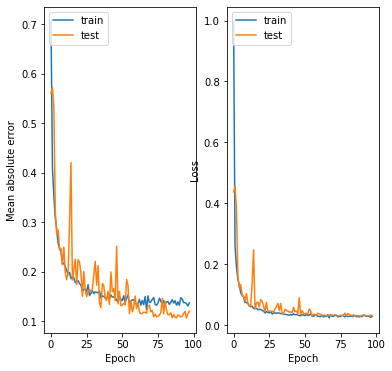

In [25]:
fig = plt.figure(figsize = (6,6))
plt.subplot(121)
# summarize history for accuracy
plt.plot(history.history['mae_metric'])
plt.plot(history.history['val_mae_metric'])
plt.ylabel('Mean absolute error')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

Make a plot showing predicted wave heights versus observed

Use the model to estimate wave height from every image (that number can be anything from 1 to the length of `test_X`)

In [26]:
pred_Y = np.squeeze(OWG.predict(test_X, batch_size = batch_size, verbose = True))

1960/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Make a plot of observed versus estimated wave height

[INFO] Plotting ...


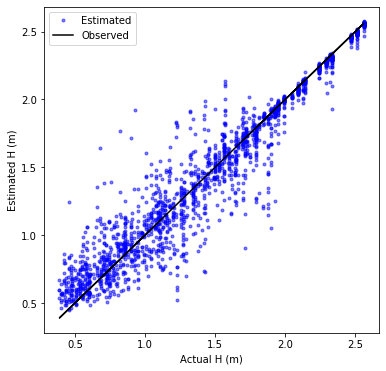

In [28]:
print ("[INFO] Plotting ...")     												        
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(test_Y, pred_Y, 'b.', alpha=0.5, label = 'Estimated')
ax1.plot(test_Y, test_Y, 'k-', label = 'Observed')
ax1.legend()
if category=='H':
   ax1.set_xlabel('Actual H (m)')
   ax1.set_ylabel('Estimated H (m)')
else:
   ax1.set_xlabel('Actual T (s)')
   ax1.set_ylabel('Estimated T (s)')    
plt.show() 

Show a few augmanted test images and their estimates wave height (and observed wave height, for comparison) 

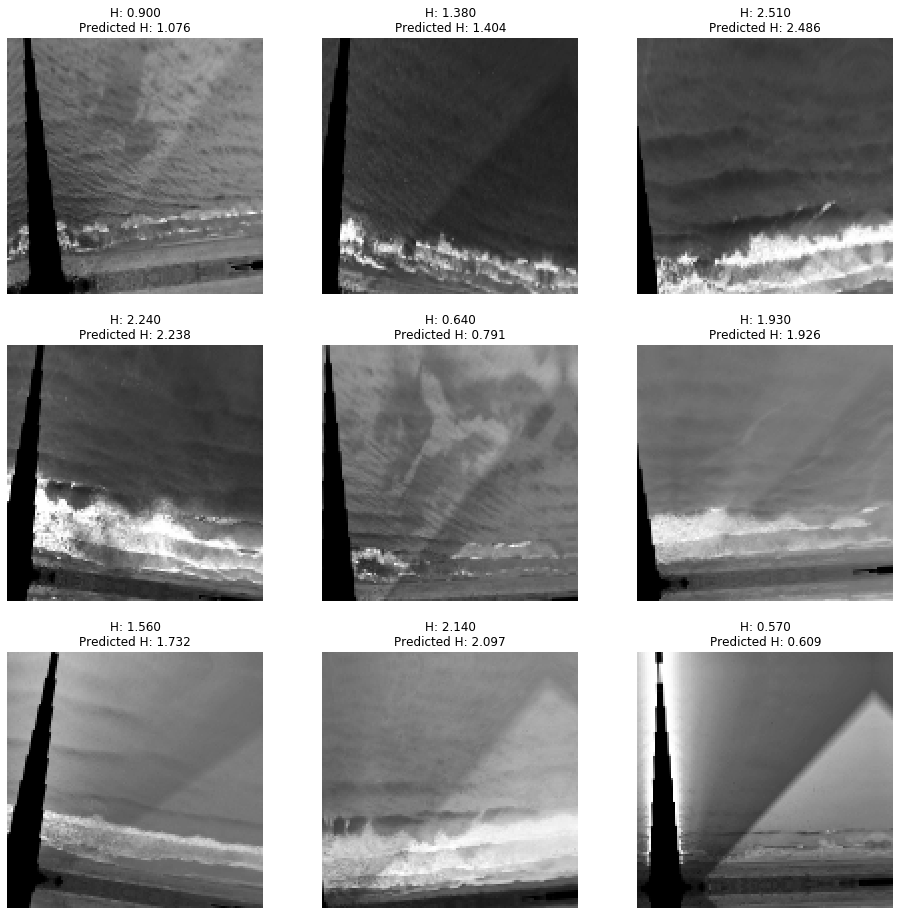

In [30]:
rand_idx = np.random.choice(range(test_X.shape[0]), 9)
fig, m_axs = plt.subplots(3, 3, figsize = (16, 16))
for (idx, c_ax) in zip(rand_idx, m_axs.flatten()):
  c_ax.imshow(test_X[idx, :,:,0], cmap = 'gray')
  if category == 'H':
      c_ax.set_title('H: %0.3f\nPredicted H: %0.3f' % (test_Y[idx], pred_Y[idx]))
  else:
      c_ax.set_title('T: %0.3f\nPredicted T: %0.3f' % (test_Y[idx], pred_Y[idx]))
  
  c_ax.axis('off')